In [13]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from langgraph.checkpoint.memory import MemorySaver # memory on langgraph to save in ram 
load_dotenv()

key = os.getenv("GROQ_API_KEY")

In [14]:
llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=key)
llm.invoke("hello")

AIMessage(content='Hello. How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.032604821, 'prompt_time': 0.001742288, 'queue_time': 0.051401137, 'total_time': 0.034347109}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--65467ecb-15e5-455f-a28c-0530ff45a6b3-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [ ]:
from langgraph.graph.message import add_messages
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages] 
    # annotated[list[str]] will be good but we will keep basemessage(coz we are talking to llm) so inside this we can have ai system tool message 
    # we have to add reducer fn, coz in state when we put new value the previous gets replaced but in our case we want to store all the messages
    # rather then operator.add we use add_messages (buitin langgraph) it is more optimize to work with base messages

In [16]:
def chatnode(state: ChatState):
    # take querry from state
    mess = state['messages']

    #send to llm
    response = llm.invoke(mess)

    #response store in state
    return {'messages': [response]}

In [17]:
checkpointer = MemorySaver() 

graph = StateGraph(ChatState)
graph.add_node("chatnode", chatnode)
graph.add_edge(START, 'chatnode')
graph.add_edge('chatnode', END)

chatbot = graph.compile()

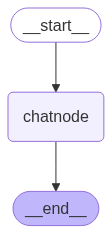

In [18]:
chatbot

In [19]:
initial_state = {
    'messages': [HumanMessage(content="hello who are you?")]
}


chatbot.invoke(initial_state)['messages'][-1]

AIMessage(content='Hello. I\'m an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 40, 'total_tokens': 65, 'completion_time': 0.043002691, 'prompt_time': 0.001939226, 'queue_time': 0.051202184, 'total_time': 0.044941917}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--7db93d6d-60b1-4fe4-b15c-469ff49c9ed1-0', usage_metadata={'input_tokens': 40, 'output_tokens': 25, 'total_tokens': 65})

In [ ]:
thread_id = '1' # lets say for use 1 shyam



# make a fee like chatbot 

while True:

   user_message =  input("Type here : ")
   print("user: ", user_message) 

   if user_message.strip().lower() in ["exit", "quit", "byy"]:
      break
   else:

      config = {'configurable':{'thread_id': thread_id}} # we will pass this while invoking 
 
      response = chatbot.invoke({"messages": [HumanMessage(content=user_message)]}, config=config) #this will be ai message
      print("ai: ", response['messages'][-1].content)   # no past memory in remembered by this chatbot

user:  my name is sam, what is your name answer in 10 words
ai:  I'm an AI, nice to meet you, Sam, my name.
user:  are you men or women
ai:  I am a computer program, so I don't have a gender. I'm an artificial intelligence designed to provide information and assist with tasks, but I don't have a physical body or personal identity. I exist solely to help users like you, and I don't have personal characteristics like gender, age, or nationality. I'm here to provide neutral and objective assistance, so please feel free to ask me anything!
user:  what is my name
ai:  I don't know your name. I'm a large language model, I don't have the ability to know personal information about you, including your name. Each time you interact with me, it's a new conversation and I don't retain any information from previous conversations. If you'd like to share your name with me, I'd be happy to chat with you!
user:  exit


in persistance we store the state value when it exists the workflow

In [21]:
chatbot.get_state(config=config)

ValueError: No checkpointer set